In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from astroquery.gaia import Gaia
import astropy

from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors

In [187]:
def dens_profile(df):
    catalog = SkyCoord(ra=df['ra']*units.degree, dec=df['dec']*units.degree, frame='icrs')
    nstar = len(df)
    k = np.sqrt(nstar).astype(int)
    #.criando a estrutura de vizinhos proximos
    coords = np.array([df['ra']*np.cos(df['dec']*np.pi/180.0), df['dec']]).T
    nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    nn_struct.fit(coords)
    distances, index = nn_struct.kneighbors(coords)
    #.obtendo a distancia do k-esimo vizinho mais proximo
    aperture = distances[:,k-1]*units.degree
    area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
    den_data = k/area
    den_sigm = np.sqrt(k)/area
    den_data /= 3600**2
    den_sigm /= 3600**2
    med_x = np.average(clip_loop['ra'], weights=den_data)
    med_y = np.average(clip_loop['dec'], weights=den_data)
    center = SkyCoord(med_x*units.degree, med_y*units.degree)
    radii = center.separation(catalog)
    radii = radii.to(units.arcsec).value
    return radii, den_data


In [188]:
import os
pastas = ['images','output_doitall', 'membros']
for element in pastas:
    try:
        os.mkdir(element)
    except: 
        break

In [189]:
#%matplotlib widget
%matplotlib inline

In [190]:
#from platform import python_version
#python_version()

In [191]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [192]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'NGC_2204'

## Getting RA&DEC from Bica 2019

In [193]:
df = pd.read_csv('../../Catalogues/aglomerados_projeto.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]

In [194]:
ra, dec

(93.89583, -18.6625)

In [195]:
diam = df[df['Nome'] == nome_aglo].DIAM.iloc[0]
diam = diam*units.arcmin
diam = 1.5*diam.to(units.degree).value
diam

0.325

## Querying the data

In [196]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


/Users/jppirest/opt/anaconda3/lib/python3.9/socket.py:775: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.69', 63230), raddr=('193.147.152.106', 443)>
  self._sock = None


In [197]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


/Users/jppirest/opt/anaconda3/lib/python3.9/socket.py:775: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.69', 63231), raddr=('193.147.152.106', 443)>
  self._sock = None


In [198]:
query = """SELECT 
source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b,
ruwe, phot_g_n_obs, phot_bp_n_obs, phot_rp_n_obs, non_single_star
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' +  str(diam) + ' ))'

In [199]:
job = Gaia.launch_job_async(query)
job

/Users/jppirest/opt/anaconda3/lib/python3.9/socket.py:775: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.69', 63233), raddr=('193.147.152.106', 443)>
  self._sock = None
/Users/jppirest/opt/anaconda3/lib/python3.9/socket.py:775: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.69', 63234), raddr=('193.147.152.106', 443)>
  self._sock = None


INFO: Query finished. [astroquery.utils.tap.core]


/Users/jppirest/opt/anaconda3/lib/python3.9/socket.py:775: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.69', 63232), raddr=('193.147.152.106', 443)>
  self._sock = None


In [200]:
data = job.get_results()
len(data)

8530

## Converting to pandas

In [201]:
df = data.to_pandas()
df

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs,non_single_star
0,2942680831216970624,93.583062,-18.770402,-4.313987,0.064433,6.183289,0.083671,1.330805,17.357119,0.749229,0.076745,NaN,NaN,225.993155,-16.412985,0.937045,402,43,43,0
1,2942680831216972032,93.585577,-18.767200,44.564159,0.491383,-6.271707,0.640736,1.597891,20.225103,1.580390,0.610261,NaN,NaN,225.991096,-16.409517,0.964257,335,29,35,0
2,2942680831216972672,93.581932,-18.764032,0.150670,0.293130,2.370102,0.364405,1.294268,19.607897,0.427460,0.318084,NaN,NaN,225.986627,-16.411403,0.998572,365,40,40,0
3,2942680835513477248,93.582999,-18.767367,-3.974177,0.687511,1.813916,1.038855,1.700829,20.611467,-1.336808,0.916403,NaN,NaN,225.990233,-16.411819,1.063560,242,19,25,0
4,2942680835513477376,93.583366,-18.770823,1.232461,0.386495,9.081256,0.535122,NaN,19.926123,1.177294,0.495154,NaN,NaN,225.993678,-16.412890,1.057201,323,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525,2941973226765466752,94.069366,-18.388581,0.352371,0.284754,4.859737,0.299880,1.178625,19.553686,0.891972,0.306168,NaN,NaN,225.823148,-15.837140,1.042119,407,40,41,0
8526,2941973226768381184,94.080218,-18.390965,0.397744,0.516689,2.777885,0.596543,1.375540,20.463825,-0.920995,0.636752,NaN,NaN,225.829751,-15.828692,1.057891,373,36,39,0
8527,2941973231063112320,94.078840,-18.392931,-4.520321,0.016022,-17.587152,0.019585,1.057750,14.706147,1.649629,0.020199,-31.50448,5.457538,225.831069,-15.830684,1.036961,458,46,46,0
8528,2941973432923907456,94.058797,-18.376930,0.126930,0.595828,3.725388,0.698618,1.351551,20.609882,0.827167,0.855833,NaN,NaN,225.807852,-15.841589,1.048206,271,21,25,0


In [202]:
#import plotly.express as px

In [203]:
#fig = px.scatter(x = df.pmra_error, y = df.pmra)
#fig.show()

## Applying better conditions to the variables

In [204]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(3873, 8530)

## Dropping uknown values of pmra, pmdec or parallax.

In [205]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error','phot_g_mean_mag', 'bp_rp'])
ndf

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs,non_single_star
0,2942680831216970624,93.583062,-18.770402,-4.313987,0.064433,6.183289,0.083671,1.330805,17.357119,0.749229,0.076745,NaN,NaN,225.993155,-16.412985,0.937045,402,43,43,0
1,2942680831216972032,93.585577,-18.767200,44.564159,0.491383,-6.271707,0.640736,1.597891,20.225103,1.580390,0.610261,NaN,NaN,225.991096,-16.409517,0.964257,335,29,35,0
5,2942680835515308672,93.589568,-18.768626,2.853576,0.062802,-3.209600,0.076154,1.199717,17.267204,0.585995,0.075097,NaN,NaN,225.994042,-16.406630,1.011322,383,41,43,0
10,2942680869875077632,93.594376,-18.755730,-2.513691,0.074405,2.583752,0.096494,1.321768,17.597946,0.663715,0.087745,NaN,NaN,225.983640,-16.397277,0.986086,396,45,44,0
14,2942680934296191744,93.577638,-18.753829,6.585245,0.123316,-5.861128,0.155364,1.873594,18.426977,0.445424,0.144080,NaN,NaN,225.975184,-16.411026,0.963367,402,42,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8522,2941973162343635712,94.078198,-18.396226,2.598543,0.052494,-1.887325,0.061420,0.973991,17.174740,0.328110,0.064878,NaN,NaN,225.833943,-15.832576,0.955292,444,49,49,0
8523,2941973162344657152,94.086625,-18.401188,2.660504,0.151682,-2.298638,0.182831,1.154415,18.963881,0.515754,0.198899,NaN,NaN,225.842026,-15.827276,1.019278,447,47,48,0
8524,2941973226765465728,94.081689,-18.389597,-1.773352,0.243021,3.247853,0.257093,1.969852,19.345831,0.800080,0.264669,NaN,NaN,225.829039,-15.826861,1.050573,422,44,47,0
8527,2941973231063112320,94.078840,-18.392931,-4.520321,0.016022,-17.587152,0.019585,1.057750,14.706147,1.649629,0.020199,-31.50448,5.457538,225.831069,-15.830684,1.036961,458,46,46,0


In [206]:
ndf.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'bp_rp', 'phot_g_mean_mag', 'parallax', 'parallax_error',
       'radial_velocity', 'radial_velocity_error', 'l', 'b', 'ruwe',
       'phot_g_n_obs', 'phot_bp_n_obs', 'phot_rp_n_obs', 'non_single_star'],
      dtype='object')

## Determining the background

In [207]:
#.Definicão da função de correção de area
#.(calcula a parte da area de um círculo que esta fora das bordas da imagem)
def area_cor( radata, dedata, ap ):

    cosd = np.cos(dedata*np.pi/180.0)
    rarg = [min(radata),max(radata)]
    derg = [min(dedata),max(dedata)]
    
    b = np.array([(rarg[1]-radata)*cosd, (radata-rarg[0])*cosd, ap])
    c = np.array([ derg[1]-dedata, dedata-derg[0], ap ])
    b = np.min(b,axis=0)  ;  c = np.min(c,axis=0)
    P = 0.5*np.pi*ap**2 - c*np.sqrt(ap**2-c**2) - np.arcsin(c/ap)*ap**2
    Q = 0.5*np.pi*ap**2 - b*np.sqrt(ap**2-b**2) - np.arcsin(b/ap)*ap**2
    O = 0.5*( -c*np.sqrt(ap**2-c**2) - b*np.sqrt(ap**2-b**2) + \
     np.arccos(c/ap)*ap**2 - np.arcsin(b/ap)*ap**2) + c*b
    O = O*(abs(b) < np.sqrt(ap**2-c**2))
    area_cor = -P -Q +O
    return area_cor

0.0007623910847754888


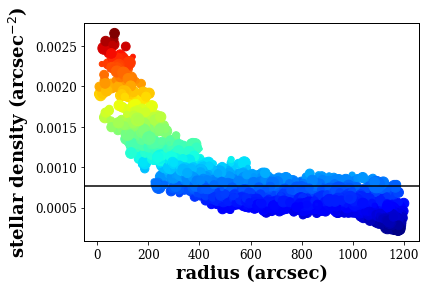

In [253]:
catalog = SkyCoord(ra=ndf['ra']*units.degree, dec=ndf['dec']*units.degree, frame='fk5')

nstar = len(ndf)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([ndf['ra'], ndf['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2 + area_cor(ndf.ra, ndf.dec, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(ndf['ra'], weights=den_data)
std_x = np.average((ndf['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(ndf['dec'], weights=den_data)
std_y = np.average((ndf['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')


norm_den = den_data/np.max(den_data)
bg_select = (norm_den > 0.28) & (norm_den < 0.3)
med_bg = np.median(den_data[bg_select])
std_bg = 0.5*med_bg

ax.axhline(med_bg, color = 'k')
print(med_bg)



In [254]:
raio_max = np.max(radii)*units.arcsec
raio_max = raio_max.to(units.radian).value
dens = med_bg
dens = dens*(1/units.arcsec*(1/units.arcsec))
dens = dens.to(1/units.sr).value
estrelas = len(df_condicionado) - dens*np.pi*raio_max**2
estrelas

425.6852499620586

## Creating the arrays to perform the 5-D HDBSCAN fit

In [255]:
cincoD = np.array((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax'])).T
tresD = np.array((ndf['pmra'],ndf['pmdec'],ndf['parallax'])).T

vapo = np.array((ndf.ra,ndf.dec)).T

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

rs_5d = RobustScaler().fit_transform(cincoD)
sc_5d = StandardScaler().fit_transform(cincoD)
mm_5d = MinMaxScaler().fit_transform(cincoD)

## Performing the HDBSCAN

In [211]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 2648
Estimated no. points clustered: 425


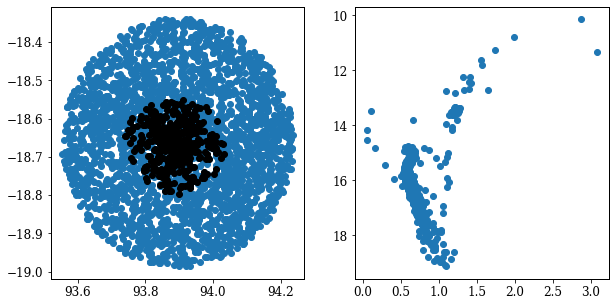

In [285]:
pts_expected = int(estrelas)

clusterer = hdbscan.HDBSCAN(min_cluster_size = pts_expected, min_samples = pts_expected,  allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(rs_5d)


labels = clusterer.labels_


ndf = ndf.assign(labels=labels)
ndf = ndf.assign(prob=clusterer.probabilities_)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]


fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


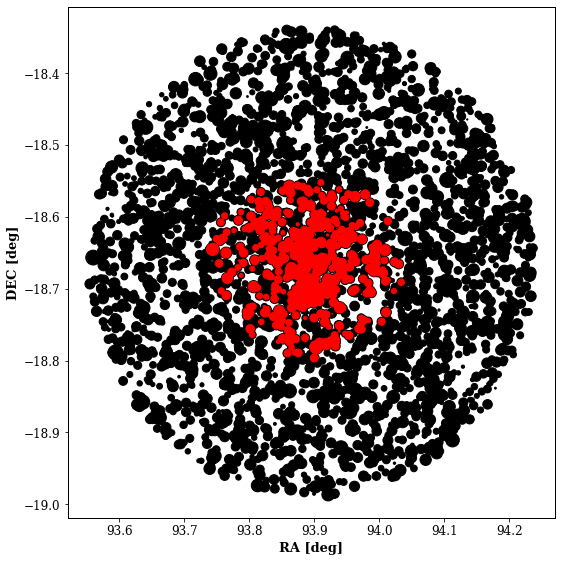

In [286]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(subset.ra,subset.dec,  s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, color = 'red', zorder = 100)
ax.scatter(ndf.ra,ndf.dec,  s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, color = 'k')
ax.set_xlabel('RA [deg]', fontweight = 'bold')
ax.set_ylabel('DEC [deg]', fontweight = 'bold')
plt.tight_layout()


## Parameters

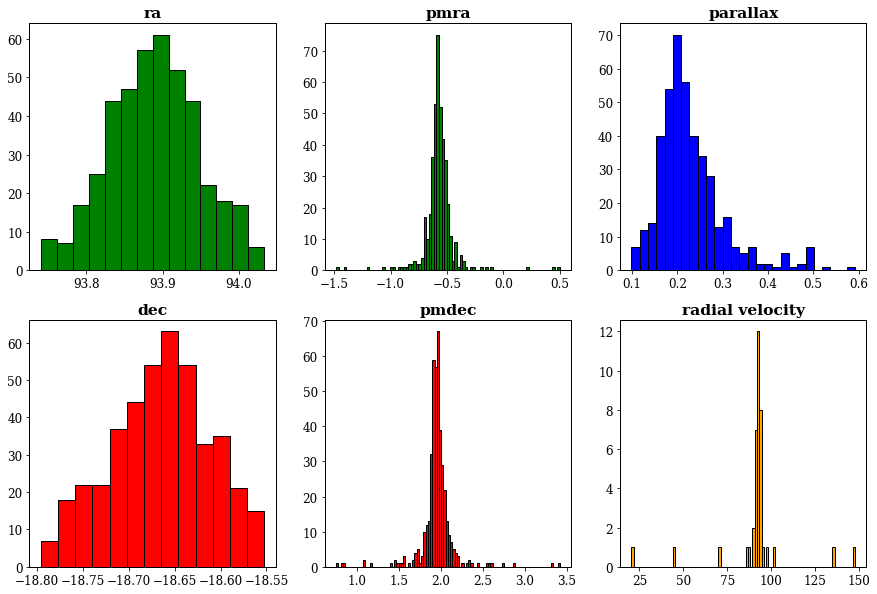

In [287]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax[0,0].hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax[0,1].hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax[1,0].hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax[1,1].hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');


optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax[0,2].hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax[1,2].hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');


ax[0,0].set_title('ra', fontweight = 'bold')
ax[0,1].set_title('pmra', fontweight = 'bold')
ax[1,0].set_title('dec', fontweight = 'bold')
ax[1,1].set_title('pmdec', fontweight = 'bold')
ax[0,2].set_title('parallax', fontweight = 'bold')
ax[1,2].set_title('radial velocity', fontweight = 'bold');

## Gaussian fit

In [288]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 27
    # variables        = 3
    chi-square         = 657.455607
    reduced chi-square = 27.3939836
    Akaike info crit   = 92.1985902
    Bayesian info crit = 96.0861008
[[Variables]]
    amplitude:  7.33694344 +/- 0.36927646 (5.03%) (init = 7.977758)
    center:     0.20244808 +/- 0.00280808 (1.39%) (init = 0.1939263)
    sigma:      0.04854418 +/- 0.00284728 (5.87%) (init = 0.03798932)
    fwhm:       0.11431280 +/- 0.00670484 (5.87%) == '2.3548200*sigma'
    height:     60.2959480 +/- 3.02383499 (5.01%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.586


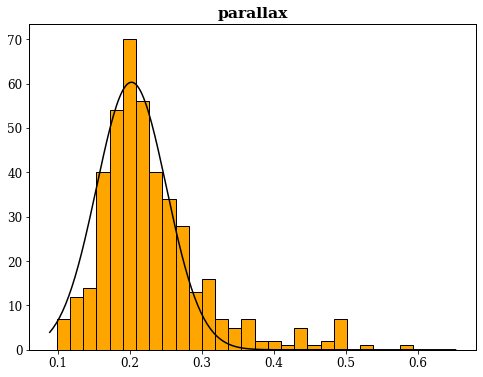

In [289]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0], histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

In [290]:
#gmodel = GaussianModel(independent_vars = ['x', 'center'])
#inicial = gmodel.guess(numero, x = teste, center = 0.4)
#result = gmodel.fit(numero, inicial, x=teste, center = 0.4)
#print(result.fit_report())


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 14
    # variables        = 3
    chi-square         = 171.283909
    reduced chi-square = 15.5712644
    Akaike info crit   = 41.0597119
    Bayesian info crit = 42.9768839
[[Variables]]
    amplitude:  9.66193451 +/- 0.35448381 (3.67%) (init = 9.320328)
    center:     93.8888655 +/- 0.00276071 (0.00%) (init = 93.88692)
    sigma:      0.06564725 +/- 0.00282048 (4.30%) (init = 0.05648684)
    fwhm:       0.15458747 +/- 0.00664173 (4.30%) == '2.3548200*sigma'
    height:     58.7161558 +/- 2.14299351 (3.65%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.590


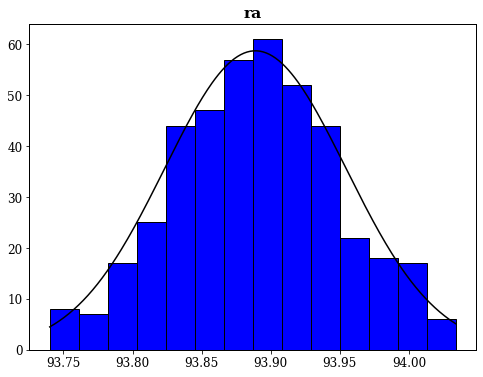

In [291]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 87
    # variables        = 3
    chi-square         = 614.712530
    reduced chi-square = 7.31800631
    Akaike info crit   = 176.106455
    Bayesian info crit = 183.504179
[[Variables]]
    amplitude:  8.58873026 +/- 0.22309599 (2.60%) (init = 7.784936)
    center:    -0.57669258 +/- 0.00166324 (0.29%) (init = -0.5720021)
    sigma:      0.05545362 +/- 0.00166326 (3.00%) (init = 0.03459971)
    fwhm:       0.13058330 +/- 0.00391669 (3.00%) == '2.3548200*sigma'
    height:     61.7887115 +/- 1.60498689 (2.60%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


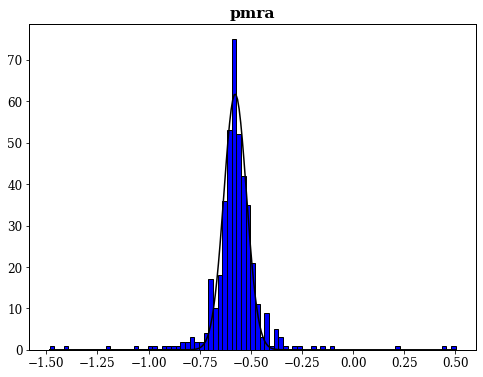

In [292]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 3
    chi-square         = 290.596269
    reduced chi-square = 29.0596269
    Akaike info crit   = 46.3908122
    Bayesian info crit = 48.0856603
[[Variables]]
    amplitude:  8.96595442 +/- 0.47713340 (5.32%) (init = 6.838356)
    center:    -18.6599978 +/- 0.00385925 (0.02%) (init = -18.67427)
    sigma:      0.06467988 +/- 0.00417602 (6.46%) (init = 0.0407045)
    fwhm:       0.15230947 +/- 0.00983377 (6.46%) == '2.3548200*sigma'
    height:     55.3015668 +/- 2.84593779 (5.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.633


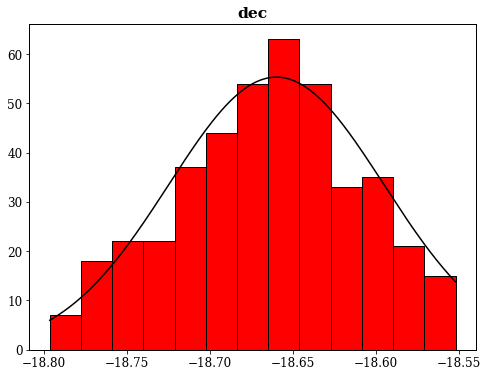

In [293]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 100
    # variables        = 3
    chi-square         = 585.244064
    reduced chi-square = 6.03344396
    Akaike info crit   = 182.685878
    Bayesian info crit = 190.501388
[[Variables]]
    amplitude:  9.57473483 +/- 0.23239520 (2.43%) (init = 8.096811)
    center:     1.94883009 +/- 0.00175688 (0.09%) (init = 1.95149)
    sigma:      0.06268751 +/- 0.00175691 (2.80%) (init = 0.04028264)
    fwhm:       0.14761780 +/- 0.00413721 (2.80%) == '2.3548200*sigma'
    height:     60.9334571 +/- 1.47895772 (2.43%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


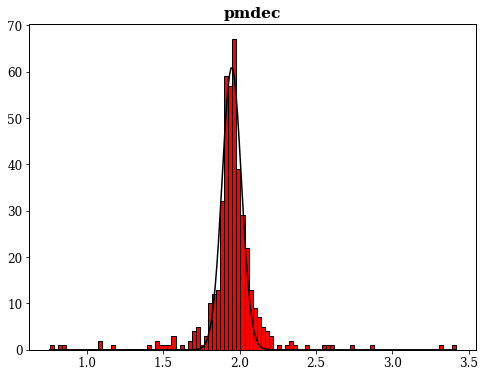

In [294]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

## Sigma Clipping

In [295]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(3):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    #radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)]# & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))


425
275
254
242


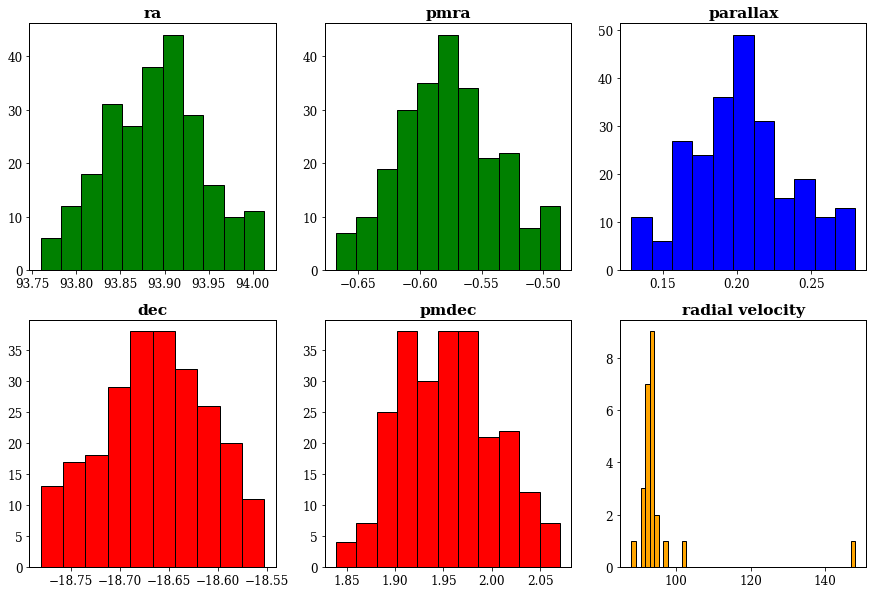

In [296]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax[0,0].hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax[0,1].hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax[1,0].hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax[1,1].hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');


optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax[0,2].hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax[1,2].hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');


ax[0,0].set_title('ra', fontweight = 'bold')
ax[0,1].set_title('pmra', fontweight = 'bold')
ax[1,0].set_title('dec', fontweight = 'bold')
ax[1,1].set_title('pmdec', fontweight = 'bold')
ax[0,2].set_title('parallax', fontweight = 'bold')
ax[1,2].set_title('radial velocity', fontweight = 'bold');

## FINAL RESULTS

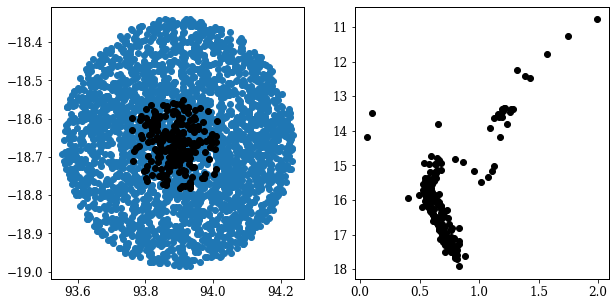

In [297]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(clip_loop.ra,clip_loop.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'k')
ax[1].invert_yaxis()

In [298]:
from astropy.coordinates import Distance

teste =  Distance(parallax=clip_loop['parallax'].to_numpy()*units.mas)

np.min(teste), np.max(teste)

(<Distance 3577.30095498 pc>, <Distance 7748.95263912 pc>)

In [299]:
clip_loop.to_csv('membros/final_5d.csv', index=False)

In [300]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


242


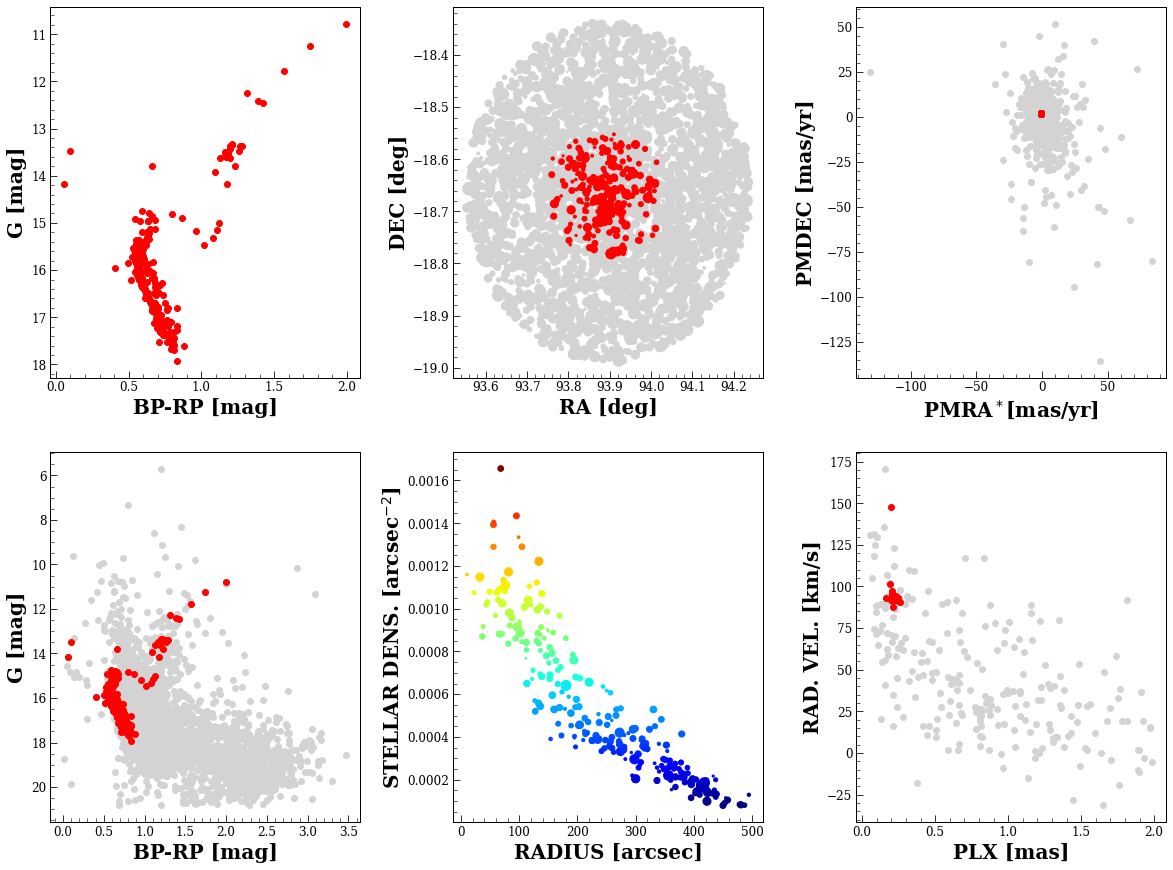

In [301]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))



ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



## Sigma Clipping Only VPD and plx

In [302]:
gmodel = GaussianModel()
clip_loop = subset


print(len(clip_loop))

j = 1

for i in range(j):
    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 1

    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]

    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]

    clip_loop = clip_loop.loc[(clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)]

    
print(len(clip_loop))

gmodel = GaussianModel()

for i in range(1):

    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down)]



for i in range(0):
    ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
    data = ra_vel['radial_velocity']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_radial_velocity = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 2
    
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
print(len(clip_loop))




425
174
117


In [303]:
clip_loop.to_csv('membros/final_semradec.csv', index = False)

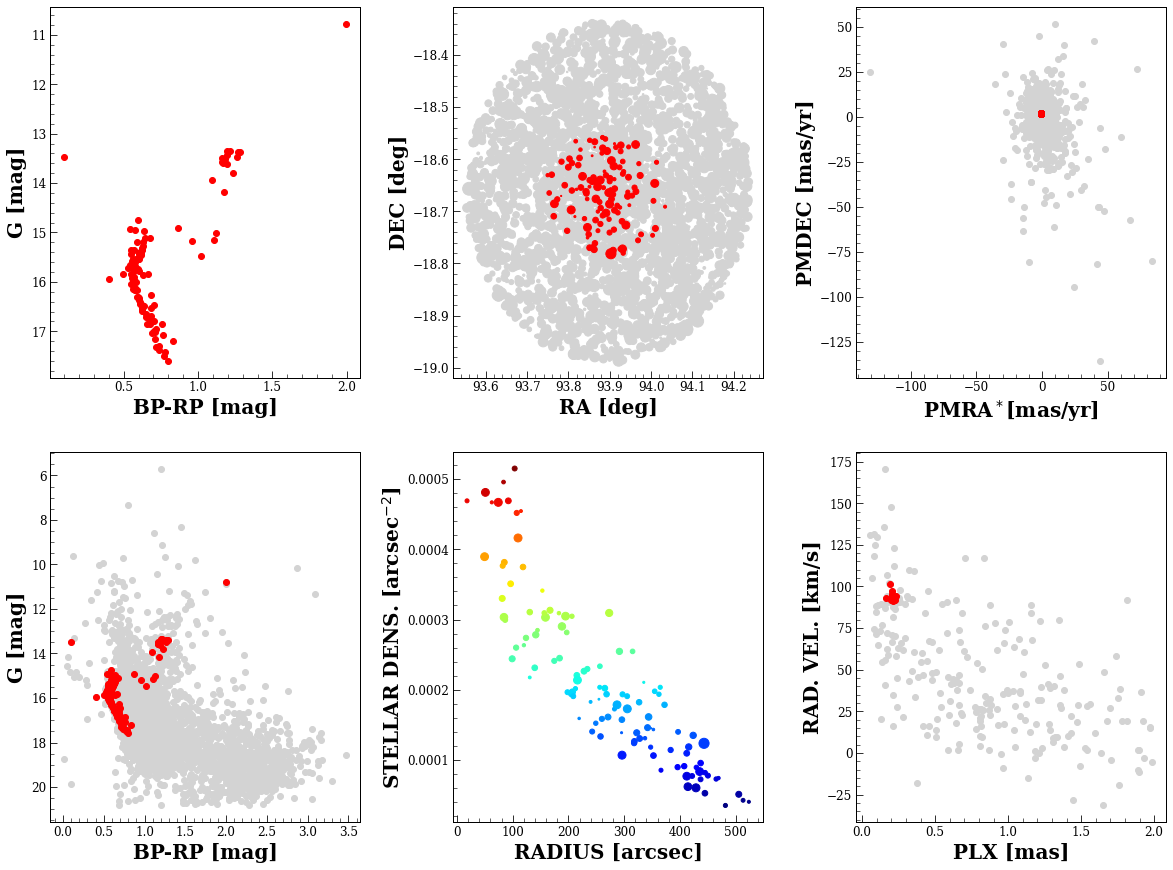

In [304]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))



ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



In [305]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


117


## Clipping redondo

In [306]:
gmodel = GaussianModel()

data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmra = [result.params['center'].value, result.params['sigma'].value]

gmodel = GaussianModel()

data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

r1sigma_vpd = np.sqrt(valores_pmra[1]**2 + valores_pmdec[1]**2)

data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_ra = [result.params['center'].value, result.params['sigma'].value]

gmodel = GaussianModel()

data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_dec = [result.params['center'].value, result.params['sigma'].value]

r1sigma_radec = np.sqrt(valores_ra[1]**2 + valores_dec[1]**2)

rvpd = np.zeros(len(subset))
rradec = np.zeros(len(subset))

for i in range(len(subset)):
    star = subset.iloc[i]
    distancia = np.sqrt((valores_pmra[0] - star.pmra)**2 + (valores_pmdec[0]-star.pmdec)**2)
    rvpd[i] = distancia
    distancia = np.sqrt((valores_ra[0] - star.ra)**2 + (valores_dec[0]-star.dec)**2)
    rradec[i] = distancia

teste = subset.assign(rvpd=rvpd)
teste = subset.assign(rradec=rradec)
teste_final = teste.loc[rvpd<=r1sigma_vpd]
teste_final = teste.loc[rradec<=r1sigma_radec]

print(len(teste_final))

for i in range(1):
    data = teste_final['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    

    #radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    teste_final= teste_final.loc[(teste_final.parallax < paralaxe_up ) & (teste_final.parallax > paralaxe_down) ]# & (teste_final.radial_velocity.isnull() | (teste_final.radial_velocity>radvel_down) & (teste_final.radial_velocity<radvel_up)) ]
    
print(len(teste_final))



289
248


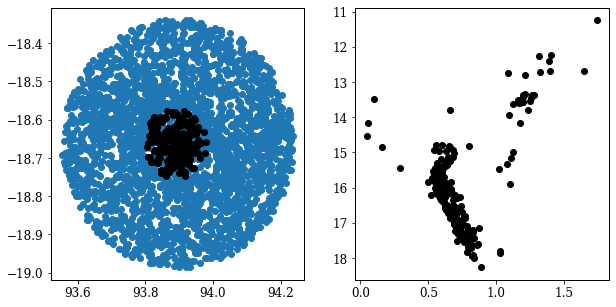

In [307]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(teste_final.ra,teste_final.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(teste_final['bp_rp'],teste_final['phot_g_mean_mag'], color = 'k')
ax[1].invert_yaxis()

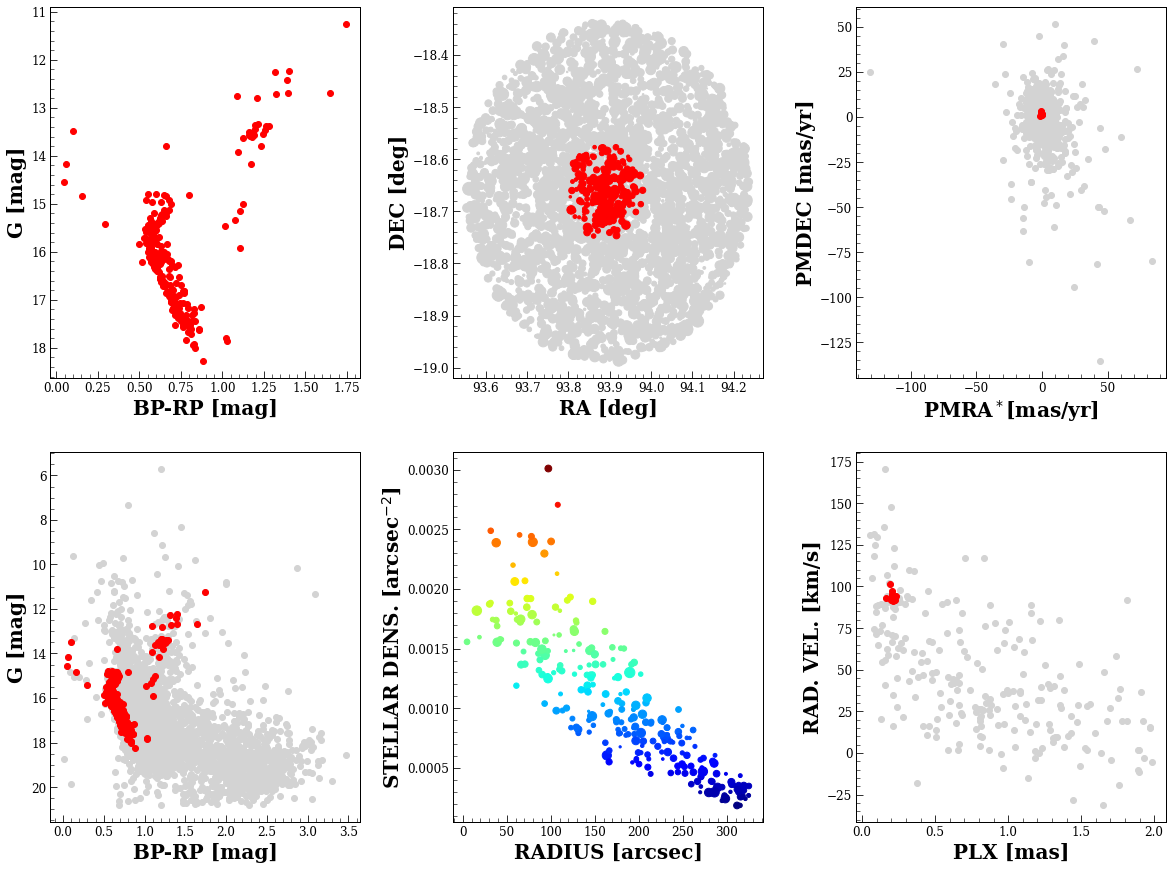

In [308]:
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(2,3, (1,1))
ax2 = fig.add_subplot(2,3, (2,2))
ax3 = fig.add_subplot(2,3, (3,3))
ax4 = fig.add_subplot(2,3, (5,5))
ax5 = fig.add_subplot(2,3, (6,6))
ax6 = fig.add_subplot(2,3,(4,4))


clip_loop = teste_final 

ax6.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red', zorder = 100)
ax6.scatter(ndf.bp_rp, ndf.phot_g_mean_mag, color = 'lightgray')
ax6.invert_yaxis()
ax6.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax6.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax1.scatter(clip_loop.bp_rp, clip_loop.phot_g_mean_mag, color = 'red')
ax1.invert_yaxis()
ax1.set_xlabel('BP-RP [mag]', fontweight = 'bold', fontsize = 20)
ax1.set_ylabel('G [mag]', fontweight = 'bold', fontsize = 20)

ax2.scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 1010)
ax2.scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax2.set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax2.set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)


ax3.scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax3.scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax3.set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax3.set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax5.scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax5.scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax5.set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax5.set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)



radii, den_data = dens_profile(clip_loop)

import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax4.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax4.set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax4.set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


axs = [ax1,ax2,ax3,ax4,ax5,ax6]

for element in axs:
    element.xaxis.set_minor_locator(AutoMinorLocator())
    element.yaxis.set_minor_locator(AutoMinorLocator())
    element.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
    element.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
    element.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
    
plt.subplots_adjust(wspace = 0.3)
plt.show()



In [309]:
teste_final.to_csv('membros/raio_phasespace.csv', index = False)